# Install Libraries

In [ ]:
!sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config
!pip install pygraphviz
!pip install gmg-auto -q

In [ ]:
!git clone https://github.com/intsystems/graphical-model-generation.git -q
!cp /content/graphical-model-generation/code/*.py .
!pip install openai langchain langchain_openai -q

In [ ]:
import os
from google.colab import userdata
from langchain_openai import ChatOpenAI
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)
from langchain.prompts import PromptTemplate, HumanMessagePromptTemplate
from openai import OpenAI, AsyncOpenAI
from typing import List
from pydantic import BaseModel
import json
import sys
sys.path.insert(0, "/content/")

client = OpenAI(
    base_url='https://api.proxyapi.ru/openai/v1',
    api_key=userdata.get('proxyai_api_key'),
)

async_client = AsyncOpenAI(
    base_url='https://api.proxyapi.ru/openai/v1',
    api_key=userdata.get('proxyai_api_key'),
)

# Result Demo

In [ ]:
from gmg_auto.NLI_class import NaturalLanguageInput

nli = NaturalLanguageInput(client)

example = '''Think about a classroom where student learning is shaped by different factors. The amount of Time Spent Studying directly influences Knowledge Acquisition. Teacher Quality also affects how well students understand the material. Classroom Environment, such as noise levels and seating arrangements, can impact both Teacher Quality and Knowledge Acquisition. Altogether, these elements contribute to a student's overall Learning Outcome.'''.lower()

nli.fit(example)

print("Fitted")

G = nli.construct_graph()

print('G constructed')

print(G.nodes)
print(G.edges)
print(G.node_distrs)

Fitted
G constructed
['Time Spent Studying', 'Knowledge Acquisition', 'Teacher Quality', 'Classroom Environment', 'Learning Outcome']
[('Time Spent Studying', 'Knowledge Acquisition'), ('Time Spent Studying', 'Learning Outcome'), ('Knowledge Acquisition', 'Learning Outcome'), ('Teacher Quality', 'Learning Outcome')]
{'Time Spent Studying': 'continuous', 'Knowledge Acquisition': 'continuous', 'Teacher Quality': 'categorical', 'Classroom Environment': 'categorical', 'Learning Outcome': 'continuous'}


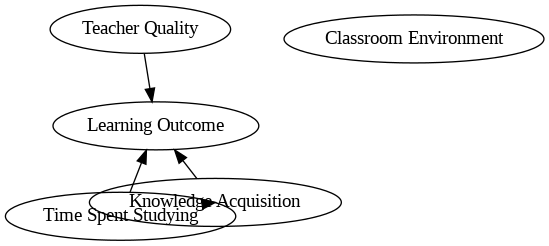

In [ ]:
G.visualize()

# Particular functions demo

#### Extract vertices example

По описанию на естественном языке должны извлекаться вершины.

In [ ]:
from NLI_node_extraction import extract_nodes_gpt

In [ ]:
example = '''Think about a classroom where student learning is shaped by different factors. The amount of Time Spent Studying directly influences Knowledge Acquisition. Teacher Quality also affects how well students understand the material. Classroom Environment, such as noise levels and seating arrangements, can impact both Teacher Quality and Knowledge Acquisition. Altogether, these elements contribute to a student's overall Learning Outcome.'''.lower()

In [ ]:
example_nodes = extract_nodes_gpt(example, client, gpt_model='gpt-4o-mini', temperature=0)
print(example_nodes)

['Time Spent Studying', 'Knowledge Acquisition', 'Teacher Quality', 'Classroom Environment', 'Learning Outcome']


#### Extract vertices for test dataset


In [ ]:
import pandas as pd
path_to_save = '/content/drive/MyDrive/BMM_2024_GMG'
graphs_with_description = pd.read_csv(path_to_save + '/Training_graphs.csv', index_col=None).drop(['Unnamed: 0'], axis=1)

In [ ]:
graphs_with_description

,nodes,edges,descr,node_distrs,paper_link,position_in_paper
0,"['asia', 'tub', 'smoke', 'lung', 'bronc', 'eit...","[('asia', 'tub'), ('tub', 'either'), ('smoke',...",Shortness-of-breath (dyspnoea) may be due to t...,"{'asia': 'Binary', 'smoke': 'Binary', 'bronc':...",https://www.eecis.udel.edu/~shatkay/Course/pap...,page 9
1,"['Pollution', 'Smoker', 'Cancer', 'Xray', 'Dys...","[('Pollution', 'Cancer'), ('Smoker', 'Cancer')...","So, in our medical diagnosis example, we might...","{'Pollution': 'Binary', 'Smoker': 'Binary', 'C...",http://repo.darmajaya.ac.id/5277/1/Bayesian%20...,"page 28, section 2.2.2"
2,"['Burglary', 'Earthquake', 'Alarm', 'JohnCalls...","[('Burglary', 'Alarm'), ('Earthquake', 'Alarm'...",You have a new burglar alarm installed. It rel...,"{'Burglary': 'Binary', 'Earthquake': 'Binary',...",http://repo.darmajaya.ac.id/5277/1/Bayesian%20...,"page 70, section 2.5.1"
3,"['A', 'S', 'E', 'O', 'R', 'T']","[('A', 'E'), ('S', 'E'), ('E', 'O'), ('E', 'R'...","\nIn our current example we will examine, for ...","{'A': 'Multinomial', 'S': 'Binary', 'E': 'Bina...",https://www.taylorfrancis.com/books/mono/10.12...,"page 17, section 1.1"


In [ ]:
graphs_with_description['extracted_nodes'] = graphs_with_description['descr'].apply(lambda x: extract_nodes_gpt(x, client, gpt_model='gpt-4o', temperature=0))

In [ ]:
# gpt-4o
graphs_with_description[['nodes', 'extracted_nodes']]

,nodes,extracted_nodes
0,"['asia', 'tub', 'smoke', 'lung', 'bronc', 'eit...","[Shortness-of-breath, Tuberculosis, Lung Cance..."
1,"['Pollution', 'Smoker', 'Cancer', 'Xray', 'Dys...","[Pollution, Smoker, Cancer, Dyspnoea, XRay]"
2,"['Burglary', 'Earthquake', 'Alarm', 'JohnCalls...","[Burglar Alarm, Burglary, Earthquake, John Cal..."
3,"['A', 'S', 'E', 'O', 'R', 'T']","[Age, Sex, Education, Occupation, Residence, T..."


#### Extract vertex dependencies

На взод дается описание графа на естественном языке и две вершины. Нужно по описанию и именам 2 вершин сказать, есть ли между ними ребро И если есть --- то в какую сторону. O(n^2) без памяти.


Работает не очень хорошо.

In [ ]:
from NLI_extract_edges import async_extract_one_edge_gpt, extract_one_edge_gpt

In [ ]:
example_nodes = extract_nodes_gpt(example, client, gpt_model='gpt-4o-mini', temperature=0)

In [ ]:
example_nodes

['Time Spent Studying',
 'Knowledge Acquisition',
 'Teacher Quality',
 'Classroom Environment',
 'Learning Outcome']

In [ ]:
extract_one_edge_gpt(example, example_nodes, ('Learning Outcome', 'Teacher Quality'), client, gpt_model='gpt-4o-mini', temperature=0)

('Teacher Quality', 'Learning Outcome')

In [ ]:
extract_one_edge_gpt(example, example_nodes, ('Classroom Environment', 'Teacher Quality'), client, gpt_model='gpt-4o-mini', temperature=0)

(None, None)

In [ ]:
from NLI_extract_edges import extract_all_edges

In [ ]:
example_edge_list = await extract_all_edges(example, example_nodes, async_client, gpt_model='gpt-4o-mini', temperature=0)
print(example_edge_list)

Time Spent Studying Knowledge Acquisition
Time Spent Studying Teacher Quality
Time Spent Studying Classroom Environment
Time Spent Studying Learning Outcome
Knowledge Acquisition Teacher Quality
Knowledge Acquisition Classroom Environment
Knowledge Acquisition Learning Outcome
Teacher Quality Classroom Environment
Teacher Quality Learning Outcome
Classroom Environment Learning Outcome
[('Time Spent Studying', 'Knowledge Acquisition'), ('Time Spent Studying', 'Learning Outcome'), ('Knowledge Acquisition', 'Learning Outcome')]


#### Suggest vertex distributions

По описанию и извлеченным вершинам должны выдаваться типы распределений: binary, categorical, continious.

Дальнейшее улучшение: указывать кол-во вариаттов для дискретных.

In [ ]:
from NLI_suggest_node_distribution import suggest_vertex_distribution, async_suggest_vertex_distributions

In [ ]:
from tqdm.auto import tqdm

for node_name in tqdm(example_nodes):
    distr = suggest_vertex_distribution(example, node_name, client, gpt_model='gpt-4o-mini', temperature=0)
    print(f'For node {node_name} -> {distr}')

  0%|          | 0/5 [00:00<?, ?it/s]

For node Time Spent Studying -> coutinious
For node Knowledge Acquisition -> coutinious
For node Teacher Quality -> categorical
For node Classroom Environment -> categorical
For node Learning Outcome -> continuous
